In [1]:
# Load Libraries
import pandas as pd
import pickle
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model, naive_bayes
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
import pybaseball as pyb
from pybaseball import statcast
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [2]:
# Import Data
df = pd.read_csv("/Users/genoc/Desktop/HyannisHarborHawks/Trackman/CapeTrackmanDatabase.csv",low_memory=False)

# Clean Trackman Data
dft = df[['Pitcher', 'PitcherTeam', 'Batter', 'BatterTeam', 'PitcherThrows', 'RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak', 'PitchCall', 'PlayResult', 'TaggedHitType', 'KorBB']]

#Rename the columns to be more descriptive
dft.rename(columns={'BatterTeam':'Batter Team', 'PitcherTeam':'Pitcher Team', 'PitcherThrows':'P Side', 'RelSpeed':'Velocity', 'SpinRate':'Spin Rate', 'RelHeight':'Release Height', 'RelSide':'Release Side', 'Extension':'Extension', 'InducedVertBreak':'Induced Vertical Break', 'HorzBreak':'Horizontal Break', 'PitchCall':'Pitch Call', 'PlayResult':'Play Result', 'TaggedHitType':'Hit Type'}, inplace=True)

#Add the Pitch Type and Pitch Result to the new dataframe
dft.insert(1, 'Pitch Type', df['TaggedPitchType'])
dft.insert(2, 'Pitch Result', df['PitchCall'])

#Create a new column for the difference between the Induced Vertical Break and the Horizontal Break (Absolute Value)
dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()

#Add two new columns for Pitch Location
dft.insert(10, 'Pitch Height', df['PlateLocHeight'])
dft.insert(11, 'Pitch Side', df['PlateLocSide'])
dft.insert(12, 'Vertical Approach Angle', df['VertApprAngle'])
dft.insert(13, 'Horizontal Approach Angle', df['HorzApprAngle'])

#Edit Horizontal Break to be absolute value of horizontal break
dft['Horizontal Break'] = abs(dft['Horizontal Break'])

dft['Release Side'] = abs(dft['Release Side'])

# Edit the pitcher names so the first name is first and the last name is last
dft['Pitcher'] = dft['Pitcher'].str.split(' ', expand=True)[1] + ' ' + dft['Pitcher'].str.split(' ', expand=True)[0]

# Edit the batter names so the first name is first and the last name is last
dft['Batter'] = dft['Batter'].str.split(' ', expand=True)[1] + ' ' + dft['Batter'].str.split(' ', expand=True)[0]

# Remove the comma from the last name
dft = dft.replace(',', '', regex=True)

# Add Swings and Misses to dft
dft['Whiff'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" else 0)
dft['Swing'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" or x == "InPlay" else 0)

# Calculates total swings and total misses across all of dft
total_swings = dft['Swing'].sum()
total_misses = dft['Whiff'].sum()

# Calculates Whiff Rate for all of dft
league_average_whiff_rate = total_misses / total_swings

# Function to Add Run Values to Dataframe

def calculate_run_values(pitch_call, play_result, TaggedHitType):
    if pitch_call == "InPlay":
        if play_result == 'Home Run':
            return 1.42595
        elif play_result == 'Double':
            return 0.7928
        elif play_result == 'Hit By Pitch':
            return 0.37665
        elif play_result == 'Out':
            return -0.2733
        elif play_result == 'FieldersChoice':
            return -0.2468
        elif play_result == 'Sacrifice' and TaggedHitType == 'Bunt':
            return -0.0883
        elif play_result == 'Sacrifice' and TaggedHitType == 'FlyBall':
            return -0.0354
        elif play_result == 'Single':
            return 0.49956
        elif play_result == 'Triple':
            return 1.16134
        elif play_result == 'Error':
            return 0.49563
    elif pitch_call == 'BallCalled':
        return 0.0715
    elif pitch_call == 'StrikeCalled':
        return -0.0821
    elif pitch_call == "StrikeSwinging": 
        return -0.126
    elif pitch_call == 'FoulBall':
        return -0.0476
    elif pitch_call == 'BallIntentional':
        return 0.10671
    else:
        return 0.0  # Return a default value if none of the conditions match


# Add 'Run Values' column using the custom function
dft['Run Values'] = dft.apply(lambda row: calculate_run_values(row['Pitch Call'], row['Play Result'], row['Hit Type']), axis=1)

# Rename 'Run Values' to 'RV'
dft.rename(columns={'Run Values': 'RV'}, inplace=True)

# Create a new dataframe with only pitches that are Four-Seam FB from RHP
dfbr = dft[(dft['Pitch Type'] == 'Fastball')]

# Handle NA values
dfbr.fillna(dfbr.mean(), inplace=True)

C:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-2-66663865a2c4>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()
<ipython-input-2-66663865a2c4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [3]:
# Stuff+ Model

dfbr['Hgt x IVB'] = dfbr['Release Height'] * dfbr['Induced Vertical Break']
dfbr['Velo^3 + Velo^2'] = pow(dfbr['Velocity'], 3) + pow(dfbr['Velocity'], 2)

dfbr['Velo^2'] = pow(dfbr['Velocity'], 2)
dfbr['Velo^3'] = pow(dfbr['Velocity'], 3)
dfbr['IndVert^2'] = pow(dfbr['Induced Vertical Break'], 2)
dfbr['DiffBreak^2'] = pow(dfbr['Differential Break'], 2)

# Filter to only include swings
dfbr_swing = dfbr[(dfbr['Swing'] == 1)]

# Linear regression Model

X = dfbr_swing[['Release Side', 'Hgt x IVB', 'Extension', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfbr_swing['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression object
linear_model = LinearRegression()

# Train the linear regression model using the training data
linear_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the linear regression model
y_linear_pred = linear_model.predict(X_test_scaled)


# Random Forest Model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest regressor object
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model using the training data
random_forest_model.fit(X_train, y_train)

# Predict Stuff+ scores for the test set using the Random Forest model
y_rf_pred = random_forest_model.predict(X_test)


# XG Boost Model

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the XGBoost regressor object
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the XGBoost model using the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the XGBoost model
y_xgb_pred = xgb_model.predict(X_test_scaled)


# SVR Model 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Support Vector Regression model
svr_model = SVR(kernel='linear')

# Train the model using the training data
svr_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the SVR model
y_pred = svr_model.predict(X_test_scaled)


# Neural Networks Model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))  # Single output neuron for the Stuff+ score prediction

# Compile the model
nn_model.compile(optimizer='adam', loss='mse')

# Train the model using the training data
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Predict Stuff+ scores for the test set using the Neural Network model
y_pred = nn_model.predict(X_test_scaled).flatten()


# Ensemble model

# Make predictions using all the models
linear_pred = linear_model.predict(X_test_scaled)
rf_pred = random_forest_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
svr_pred = svr_model.predict(X_test_scaled)
keras_nn_pred = nn_model.predict(X_test_scaled).flatten()

# Combine predictions using averaging
ensemble_predictions = (linear_pred + rf_pred + xgb_pred + svr_pred + keras_nn_pred) / 5.0


# Fit the model to the data

X = dfbr[['Release Side', 'Hgt x IVB', 'Extension', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfbr['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Make predictions on the training set using all the models
linear_pred_train = linear_model.predict(X_train_scaled)
rf_pred_train = random_forest_model.predict(X_train_scaled)
xgb_pred_train = xgb_model.predict(X_train_scaled)
svr_pred_train = svr_model.predict(X_train_scaled)
keras_nn_pred_train = nn_model.predict(X_train_scaled).flatten()

# Make predictions on the test set using all the models
linear_pred_test = linear_model.predict(X_test_scaled)
rf_pred_test = random_forest_model.predict(X_test_scaled)
xgb_pred_test = xgb_model.predict(X_test_scaled)
svr_pred_test = svr_model.predict(X_test_scaled)
keras_nn_pred_test = nn_model.predict(X_test_scaled).flatten()

# Combine predictions using averaging for the training set
ensemble_predictions_train = (linear_pred_train + rf_pred_train + xgb_pred_train + svr_pred_train + keras_nn_pred_train) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the training set
ensemble_df_train = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_train}, index=X_train.index)

# Combine predictions using averaging for the test set
ensemble_predictions_test = (linear_pred_test + rf_pred_test + xgb_pred_test + svr_pred_test + keras_nn_pred_test) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the test set
ensemble_df_test = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_test}, index=X_test.index)

# Concatenate the training and test set DataFrames
ensemble_df = pd.concat([ensemble_df_train, ensemble_df_test])

# Calculate the 'Stuff+' values
dfbr['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100

# Sort the DataFrame by 'Stuff+' values in descending order
dfbr_stuff_sorted = dfbr.sort_values(by='Stuff+', ascending=False)

# Reset the index of the sorted DataFrame
dfbr_stuff_sorted.reset_index(drop=True, inplace=True)

average_fb_Stuff = dfbr_stuff_sorted[dfbr_stuff_sorted['Pitch Type'] == 'Fastball'].groupby('Pitcher')['Stuff+'].mean()
average_fb_Stuff = average_fb_Stuff.round(2)

# Sort the Series in descending order based on the average Stuff+ values
average_fb_Stuff_sorted = average_fb_Stuff.sort_values(ascending=False)

<ipython-input-3-a20fae3ccc76>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfbr['Hgt x IVB'] = dfbr['Release Height'] * dfbr['Induced Vertical Break']
<ipython-input-3-a20fae3ccc76>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfbr['Velo^3 + Velo^2'] = pow(dfbr['Velocity'], 3) + pow(dfbr['Velocity'], 2)
<ipython-input-3-a20fae3ccc76>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

103/103 [==============================] - 0s 1ms/step


<ipython-input-3-a20fae3ccc76>:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfbr['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100


In [4]:
# Location+ Models

In [5]:
# Linear regression Model

X = dfbr[['Pitch Height', 'Pitch Side']]
# X = dfbr_swing[['Pitch Height', 'Pitch Side', 'Release Height', 'Release Side', 'Extension', 'Horizontal Approach Angle', 'Vertical Approach Angle']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfbr['RV']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression object
linear_model = LinearRegression()

# Train the linear regression model using the training data
linear_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the linear regression model
y_linear_pred = linear_model.predict(X_test_scaled)

In [6]:
# Random Forest Model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest regressor object
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model using the training data
random_forest_model.fit(X_train, y_train)

# Predict Stuff+ scores for the test set using the Random Forest model
y_rf_pred = random_forest_model.predict(X_test)

In [7]:
# XG Boost Model

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the XGBoost regressor object
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the XGBoost model using the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the XGBoost model
y_xgb_pred = xgb_model.predict(X_test_scaled)

In [8]:
# SVR Model 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Support Vector Regression model
svr_model = SVR(kernel='linear')

# Train the model using the training data
svr_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the SVR model
y_pred = svr_model.predict(X_test_scaled)

In [9]:
# Neural Networks Model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))  # Single output neuron for the Stuff+ score prediction

# Compile the model
nn_model.compile(optimizer='adam', loss='mse')

# Train the model using the training data
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Predict Stuff+ scores for the test set using the Neural Network model
y_pred = nn_model.predict(X_test_scaled).flatten()

103/103 [==============================] - 0s 1ms/step


In [10]:
# Ensemble model

# Make predictions using all the models
linear_pred = linear_model.predict(X_test_scaled)
rf_pred = random_forest_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
svr_pred = svr_model.predict(X_test_scaled)
keras_nn_pred = nn_model.predict(X_test_scaled).flatten()

# Combine predictions using averaging
ensemble_predictions = (linear_pred + rf_pred + xgb_pred + svr_pred + keras_nn_pred) / 5.0

103/103 [==============================] - 0s 2ms/step


In [11]:
X = dfbr[['Pitch Height', 'Pitch Side']]
y = dfbr['RV']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Make predictions on the training set using all the models
linear_pred_train = linear_model.predict(X_train_scaled)
rf_pred_train = random_forest_model.predict(X_train_scaled)
xgb_pred_train = xgb_model.predict(X_train_scaled)
svr_pred_train = svr_model.predict(X_train_scaled)
keras_nn_pred_train = nn_model.predict(X_train_scaled).flatten()

411/411 [==============================] - 1s 1ms/step


In [13]:
# Make predictions on the test set using all the models
linear_pred_test = linear_model.predict(X_test_scaled)
rf_pred_test = random_forest_model.predict(X_test_scaled)
xgb_pred_test = xgb_model.predict(X_test_scaled)
svr_pred_test = svr_model.predict(X_test_scaled)
keras_nn_pred_test = nn_model.predict(X_test_scaled).flatten()

103/103 [==============================] - 0s 1ms/step


In [14]:
# Combine predictions using averaging for the training set
ensemble_predictions_train = (linear_pred_train + rf_pred_train + xgb_pred_train + svr_pred_train + keras_nn_pred_train) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the training set
ensemble_df_train = pd.DataFrame({'xRV': ensemble_predictions_train}, index=X_train.index)

In [15]:
# Combine predictions using averaging for the test set
ensemble_predictions_test = (linear_pred_test + rf_pred_test + xgb_pred_test + svr_pred_test + keras_nn_pred_test) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the test set
ensemble_df_test = pd.DataFrame({'xRV': ensemble_predictions_test}, index=X_test.index)

In [16]:
# Concatenate the training and test set DataFrames
ensemble_df = pd.concat([ensemble_df_train, ensemble_df_test])

In [17]:
# Predict using the model and store results in a new DataFrame

# Merge the predictions with the original DataFrame based on index
dfbr = dfbr.merge(ensemble_df[['xRV']], left_index=True, right_index=True)

# Create a new column with predicted run value times 100 called xRV/100
dfbr['xRV/100'] = dfbr['xRV'] * 100

In [18]:
# Create a new column called xRV/100 scaled negative which is xRV/100 - max(xRV/100)
dfbr = dfbr.assign(xRV100_scaled_negative=dfbr['xRV/100'] - dfbr['xRV/100'].max())

# Create a new column which is the absolute value of xRV/100 scaled negative
dfbr = dfbr.assign(xRV100_scaled_negative_abs=dfbr['xRV100_scaled_negative'].abs())

In [19]:
# Calculate the Location+ mean for the whole datset
mean_location_plus = dfbr['xRV100_scaled_negative_abs'].mean()

# Calculate the 'Location+' values
dfbr['Location+'] = (dfbr['xRV100_scaled_negative_abs'] / mean_location_plus) * 100

In [20]:
dfbr['Location+'].describe()

count    16427.000000
mean       100.000000
std         19.755316
min          0.000000
25%         85.520129
50%        104.790764
75%        116.095131
max        153.217162
Name: Location+, dtype: float64

In [21]:
# Sort the DataFrame by 'Location+' values in descending order
dfbr_location_sorted = dfbr.sort_values(by='Location+', ascending=False)

# Reset the index of the sorted DataFrame
dfbr_location_sorted.reset_index(drop=True, inplace=True)

dfbr_location_sorted = dfbr_location_sorted[['Pitcher', 'Pitch Type', 'Pitch Result', 'Pitcher Team', 'P Side', 'Velocity', 'RV', 'Pitch Height', 'Pitch Side', 'Location+']]

In [23]:
dfbr_trial = dfbr_location_sorted[['Pitcher', 'Pitch Result', 'Pitch Height', 'Pitch Side', 'Location+']]
dfbr_trial = dfbr_trial.head(5)

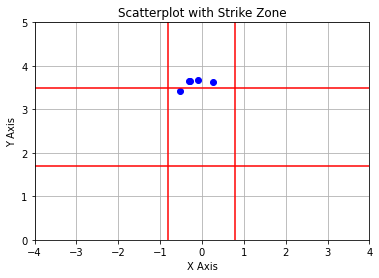

In [24]:
# Define the strike zone boundaries
y_boundarylow = 1.7
y_boundaryhigh = 3.5

x_boundarylow = -0.8
x_boundaryhigh = 0.8

# Create a scatterplot
plt.scatter(dfbr_trial['Pitch Side'], dfbr_trial['Pitch Height'], color='blue', label='Data Points')

# Add the strike zone lines
plt.axvline(x=x_boundarylow, color='red', linestyle='-', label='Strike Zone')
plt.axvline(x=x_boundaryhigh, color='red', linestyle='-')
plt.axhline(y=y_boundarylow, color='red', linestyle='-')
plt.axhline(y=y_boundaryhigh, color='red', linestyle='-')

# Set labels and title
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Scatterplot with Strike Zone')

# Set plot limits
plt.xlim(-4, 4)
plt.ylim(0, 5)

# Show the plot
plt.grid()
plt.show()


In [25]:
dfbr = dfbr.round(2)
average_fb_location = dfbr.groupby('Pitcher')['Location+'].mean()

# Sort the Series in descending order based on the average Stuff+ values
average_fb_location_sorted = average_fb_location.sort_values(ascending=False)

In [26]:
average_fb_location_sorted.round(2).head(30)

Pitcher
Randall Alejo       133.78
Justin Lovell       122.04
Ben Jacobs          118.19
Will Jones          117.40
Garrett Coe         115.19
Tyler LeBlanc       114.41
JB Middleton        114.19
Zachary Joyce       111.85
Carson Swilling     111.46
Matt Wilkinson      110.61
Blake Purnell       109.91
Nolan Morr          109.87
Matt Boynton        109.77
Jack Bowery         109.58
AJ Causey           109.25
David Falco         108.99
Chase Hopewell      108.70
John Holobetz       108.64
Coulson Buchanan    108.64
Anthony Defabbia    107.61
Bryce Eblin         107.61
Andrew Shaffner     107.23
Thomas Splaine      107.22
Tony Robie          107.17
Aiden Jimenez       107.13
Max Banks           107.03
Kyle Scott          106.95
Mark Manfredi       106.86
Trevin Hope         106.77
Derek Clark         106.58
Name: Location+, dtype: float64

In [45]:
# Calculate the average Location+ for each pitcher
pitcher_location_avg = dfbr.groupby('Pitcher')['Location+'].mean()

# Calculate the average Stuff+ for each pitcher
pitcher_stuff_avg = dfbr.groupby('Pitcher')['Stuff+'].mean()

# Combine the averages into a new DataFrame
final_pitching_df = pd.DataFrame({
    'Pitcher': pitcher_location_avg.index,
    'Pitcher Team': dfbr.groupby('Pitcher')['Pitcher Team'].first(),
    'Location+': pitcher_location_avg,
    'Stuff+': pitcher_stuff_avg
}).reset_index(drop=True)

In [46]:
final_pitching_df_sorted = final_pitching_df.sort_values(by='Stuff+', ascending=False)
final_pitching_df_top30 = final_pitching_df_sorted.head(30)

In [47]:
final_pitching_df_top30['Location+'].mean()

100.32286150827979

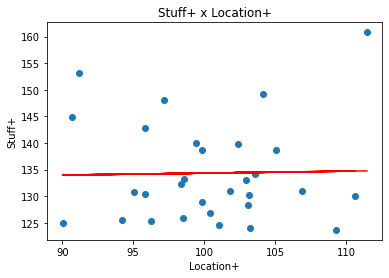

R-squared value: 0.0004457439905086735


In [52]:
# Create a scatter plot

x = final_pitching_df_top30['Location+']
y = final_pitching_df_top30['Stuff+']

plt.scatter(x, y)

# Perform linear regression
slope, intercept = np.polyfit(x, y, 1)
regression_line = np.polyval([slope, intercept], x)

# Calculate R-squared value
residuals = y - regression_line
ss_residuals = np.sum(residuals**2)
ss_total = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_residuals / ss_total)

# Add labels and title
plt.xlabel('Location+')
plt.ylabel('Stuff+')
plt.title('Stuff+ x Location+')

# Display the plot
plt.plot(x, regression_line, color='red')  # Plot the regression line
plt.show()

# Display the R-squared value
print(f'R-squared value: {r_squared}')

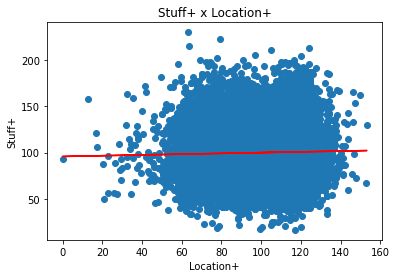

R-squared value: 0.0009524331972980971


In [53]:
# Create a scatter plot

x = dfbr['Location+']
y = dfbr['Stuff+']

plt.scatter(x, y)

# Perform linear regression
slope, intercept = np.polyfit(x, y, 1)
regression_line = np.polyval([slope, intercept], x)

# Calculate R-squared value
residuals = y - regression_line
ss_residuals = np.sum(residuals**2)
ss_total = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_residuals / ss_total)

# Add labels and title
plt.xlabel('Location+')
plt.ylabel('Stuff+')
plt.title('Stuff+ x Location+')

# Display the plot
plt.plot(x, regression_line, color='red')  # Plot the regression line
plt.show()

# Display the R-squared value
print(f'R-squared value: {r_squared}')

In [54]:
final_pitching_df_sorted = final_pitching_df.sort_values(by='Location+', ascending=False)
final_pitching_df_top30 = final_pitching_df_sorted.head(30)

In [55]:
final_pitching_df_top30['Stuff+'].mean()

95.57380445877651

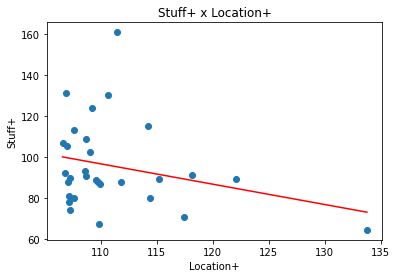

R-squared value: 0.07360175971686833


In [56]:
# Create a scatter plot

x = final_pitching_df_top30['Location+']
y = final_pitching_df_top30['Stuff+']

plt.scatter(x, y)

# Perform linear regression
slope, intercept = np.polyfit(x, y, 1)
regression_line = np.polyval([slope, intercept], x)

# Calculate R-squared value
residuals = y - regression_line
ss_residuals = np.sum(residuals**2)
ss_total = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_residuals / ss_total)

# Add labels and title
plt.xlabel('Location+')
plt.ylabel('Stuff+')
plt.title('Stuff+ x Location+')

# Display the plot
plt.plot(x, regression_line, color='red')  # Plot the regression line
plt.show()

# Display the R-squared value
print(f'R-squared value: {r_squared}')

In [58]:
final_pitching_df_top30.round(2)

,Pitcher,Pitcher Team,Location+,Stuff+
248,Randall Alejo,Harwich,133.78,64.35
186,Justin Lovell,Bourne,122.04,89.37
18,Ben Jacobs,Bourne,118.19,91.22
307,Will Jones,Harwich,117.40,70.82
121,Garrett Coe,Falmouth,115.19,89.28
303,Tyler LeBlanc,Hyannis,114.41,79.70
140,JB Middleton,Hyannis,114.19,115.17
315,Zachary Joyce,Cotuit,111.85,87.97
54,Carson Swilling,Brewster,111.46,160.80
218,Matt Wilkinson,Chatham,110.61,130.03


In [ ]:
# Pitching+ Model

In [59]:
dfbr['Pitching+'] = (0.6 * dfbr['Stuff+']) + (0.4 * dfbr['Location+'])

In [60]:
dfbr['Pitching+'].describe()

count    16427.000000
mean       100.000093
std         18.053729
min         38.456000
25%         88.683000
50%         98.414000
75%        111.182000
max        177.382000
Name: Pitching+, dtype: float64

In [62]:
final_pitching_df_sorted = dfbr.sort_values(by='Pitching+', ascending=False)
final_pitching_df_top30 = final_pitching_df_sorted.head(30)

In [66]:
final_pitching_df_top30[['Pitcher', 'Pitch Result', 'Pitcher Team', 'P Side', 'xRV', 'Stuff+', 'Location+', 'Pitching+']]

,Pitcher,Pitch Result,Pitcher Team,P Side,xRV,Stuff+,Location+,Pitching+
37791,Andrew Sentlinger,StrikeSwinging,Brewster,Left,-0.02,212.97,124.00,177.382
54109,Matt Maloney,StrikeCalled,Hyannis,Right,-0.02,204.16,119.93,170.468
17016,Carlos Rey,StrikeSwinging,Chatham,Left,-0.01,210.38,105.15,168.288
48405,Konner Eaton,StrikeCalled,Orleans,Left,-0.02,195.74,124.23,167.136
17013,Carlos Rey,StrikeCalled,Chatham,Left,-0.02,199.61,116.28,166.278
37788,Andrew Sentlinger,StrikeSwinging,Brewster,Left,-0.03,190.91,127.35,165.486
57557,Tanner Witt,StrikeSwinging,Chatham,Right,-0.02,197.89,116.54,165.350
37790,Andrew Sentlinger,BallCalled,Brewster,Left,0.02,222.44,79.38,165.216
24636,Matt Wilkinson,StrikeSwinging,Chatham,Left,-0.03,185.72,133.24,164.728
2644,Greysen Carter,BallCalled,Orleans,Right,-0.03,184.81,134.11,164.530


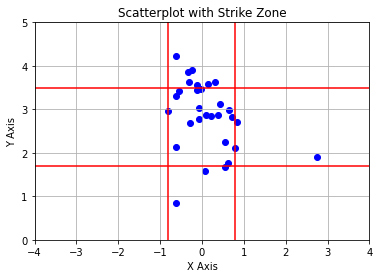

In [64]:
# Define the strike zone boundaries
y_boundarylow = 1.7
y_boundaryhigh = 3.5

x_boundarylow = -0.8
x_boundaryhigh = 0.8

# Create a scatterplot
plt.scatter(final_pitching_df_top30['Pitch Side'], final_pitching_df_top30['Pitch Height'], color='blue', label='Data Points')

# Add the strike zone lines
plt.axvline(x=x_boundarylow, color='red', linestyle='-', label='Strike Zone')
plt.axvline(x=x_boundaryhigh, color='red', linestyle='-')
plt.axhline(y=y_boundarylow, color='red', linestyle='-')
plt.axhline(y=y_boundaryhigh, color='red', linestyle='-')

# Set labels and title
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Scatterplot with Strike Zone')

# Set plot limits
plt.xlim(-4, 4)
plt.ylim(0, 5)

# Show the plot
plt.grid()
plt.show()


In [ ]:
# RESULTS

# 100.3 location+ average on Cape for the top 30 Stuff+ profiles for FB

# 95.6 Stuff+ average on Cape for the top 30 Location+ profiles for FB